In [1]:
!pip install tensorflow==1.15

In [2]:
from keras.datasets import cifar100
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


# **Train *GAN***

Define *GAN* class:

In [3]:
(X_train, _), (_, _) = cifar100.load_data()
X_train.shape

169009152/169001437 [==============================] - 11s 0us/step


(50000, 32, 32, 3)

In [4]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 128
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)


    def train(self, epochs, batch_size, sample_interval):

        #--------------load data---------------
        (X_train, _), (_, _) = cifar100.load_data()

        #---------------normalize----------------
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        #-----------labels--------------
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
        #--------- Get some random images from dataset. How many images? in the size of the batch size ------------
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

        #---------------- generate some random images. How many images? batch size --------------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

        #----------------------------------------- define loss -----------------------------------------------------

        #-----------------First train discriminator in order to discriminate real and fake images ------------------
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)

            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #-------------------------Then train combine model in order to full the discriminate --------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)


            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.close()

Train *GAN*:

In [6]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=256, sample_interval=1000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.656917, acc.: 57.03%] [G loss: 0.516925]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
5001 [D loss: 0.429259, acc.: 80.66%] [G loss: 1.854189]
5002 [D loss: 0.359032, acc.: 85.16%] [G loss: 2.214140]
5003 [D loss: 0.456382, acc.: 80.08%] [G loss: 1.938187]
5004 [D loss: 0.432643, acc.: 77.93%] [G loss: 2.112141]
5005 [D loss: 0.440620, acc.: 79.10%] [G loss: 2.366478]
5006 [D loss: 0.423383, acc.: 82.42%] [G loss: 1.738022]
5007 [D loss: 0.433093, acc.: 81.05%] [G loss: 1.906774]
5008 [D loss: 0.428805, acc.: 82.03%] [G loss: 1.969417]
5009 [D loss: 0.609460, acc.: 68.55%] [G loss: 1.929988]
5010 [D loss: 0.538681, acc.: 73.63%] [G loss: 1.768886]
5011 [D loss: 0.488165, acc.: 78.71%] [G loss: 1.664508]
5012 [D loss: 0.404573, acc.: 82.03%] [G loss: 1.747811]
5013 [D loss: 0.464745, acc.: 80.08%] [G loss: 1.778970]
5014 [D loss: 0.405890, acc.: 81.84%] [G loss: 2.284026]
5015 [D loss: 0.313253, acc.: 86.33%] [G loss: 2.892813]
5016 [D loss: 0.321196, acc.: 86.91%] [G loss: 3.067176]
5017 [D loss: 0.412540, acc.: 80.86%]

# ***Visualize* the generated examples:**

In [7]:
noise = np.random.normal(0, 1, (20,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

(20, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

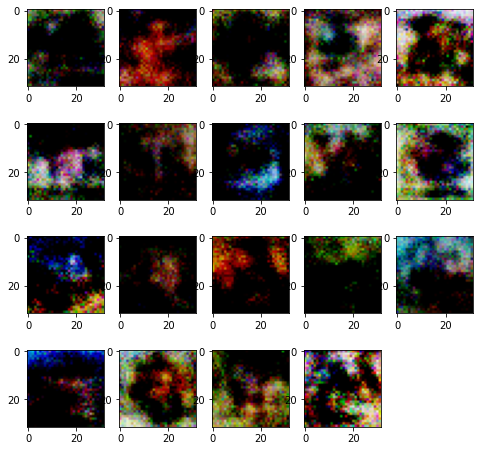

In [8]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
plt.show()

In [9]:
noise = np.random.normal(0, 1, (30,128))
gen_imgs = gan.generator.predict(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

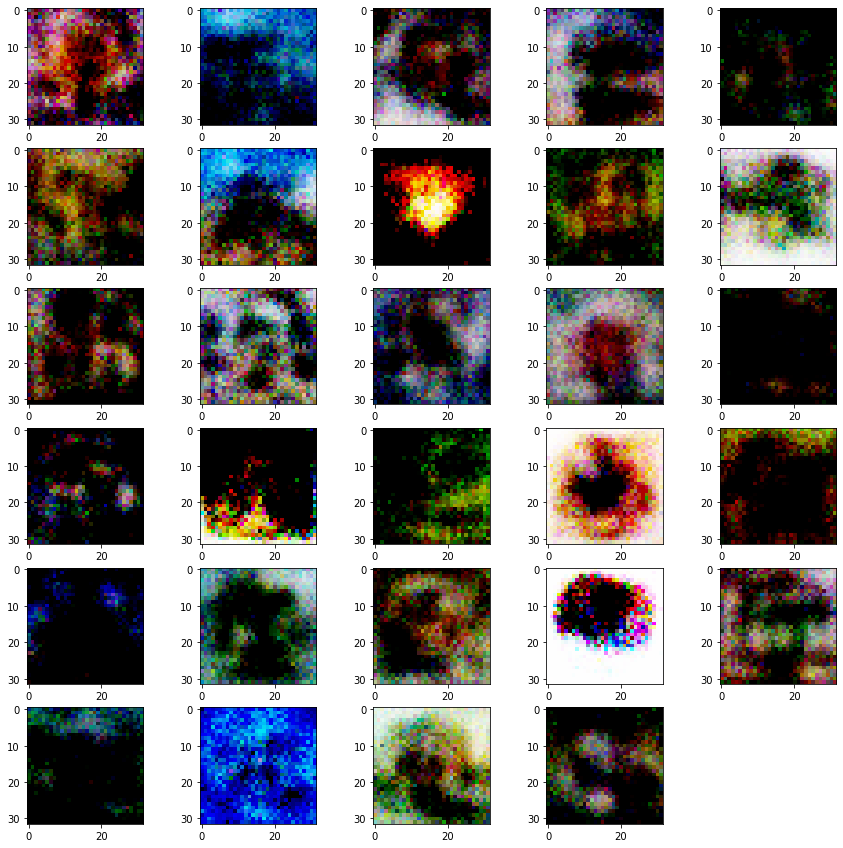

In [10]:
fig = plt.figure(figsize=(15,15))
columns = 5
rows = 6
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
plt.show()